In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install openpyxl

In [3]:
# Load the provided files
data_dict_path = "Leads Data Dictionary.xlsx"
leads_data_path = "Leads.csv"

# Read the data dictionary and leads dataset
data_dictionary = pd.read_excel(data_dict_path)
leads_data = pd.read_csv(leads_data_path)

# Display the first few rows of the data dictionary and leads dataset for review
data_dictionary_info = data_dictionary.head()
leads_data_info = leads_data.head()

# Check for missing values and basic statistics in the leads dataset
missing_values = leads_data.isnull().sum()
data_summary = leads_data.describe(include='all').T

# Output the summaries for analysis
data_dictionary_info, leads_data_info, missing_values, data_summary


(   Unnamed: 0   Unnamed: 1                                         Unnamed: 2
 0         NaN          NaN                                                NaN
 1         NaN    Variables                                        Description
 2         NaN  Prospect ID  A unique ID with which the customer is identif...
 3         NaN  Lead Number      A lead number assigned to each lead procured.
 4         NaN  Lead Origin  The origin identifier with which the customer ...,
                             Prospect ID  Lead Number              Lead Origin  \
 0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
 1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
 2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
 3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
 4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   
 
       Lead Source Do Not Email

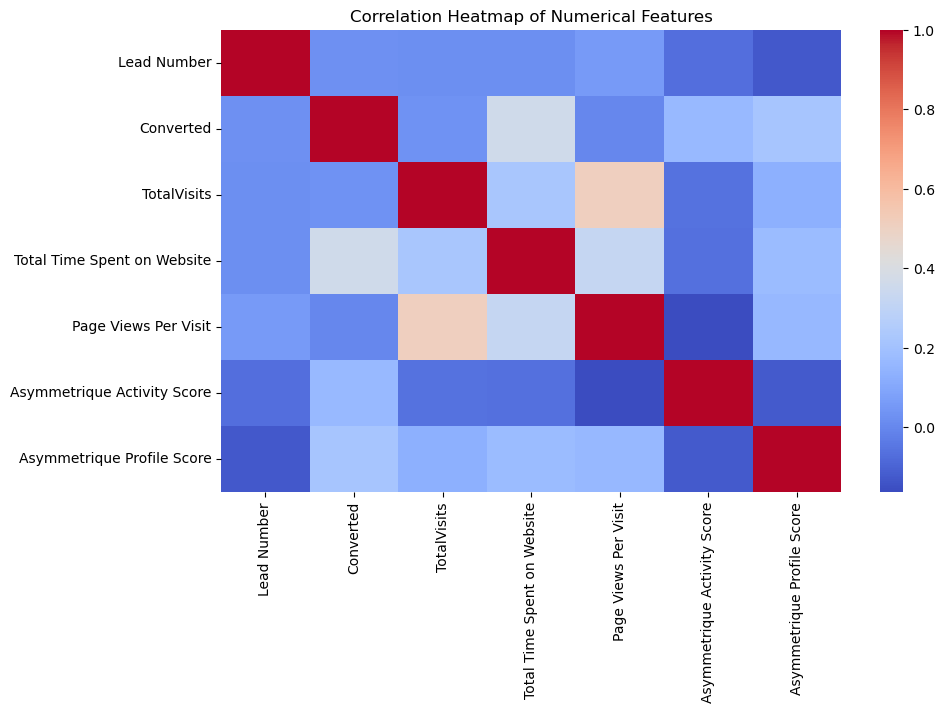

In [4]:
# Correlation heatmap (numerical features only)
numerical_data = leads_data.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_data.corr(), annot=False, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

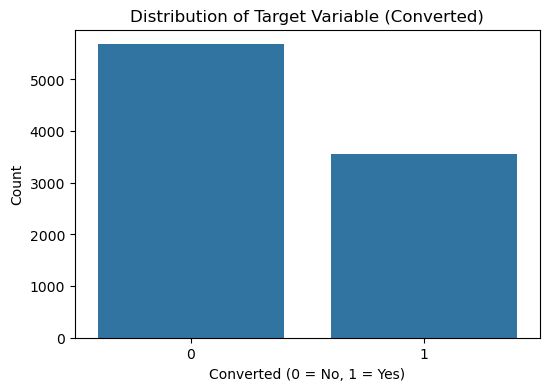

In [5]:
# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Converted', data=leads_data)
plt.title("Distribution of Target Variable (Converted)")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

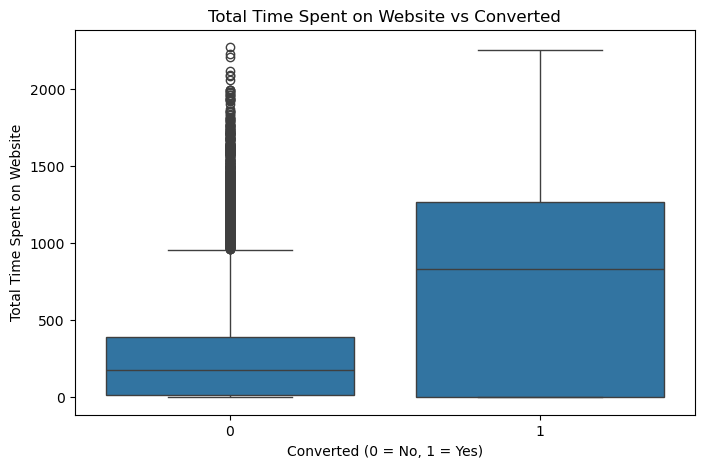

In [6]:
# Boxplot for a key numerical variable vs target
plt.figure(figsize=(8, 5))
sns.boxplot(x='Converted', y='Total Time Spent on Website', data=leads_data)
plt.title("Total Time Spent on Website vs Converted")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Total Time Spent on Website")
plt.show()

C:\Users\gaura\AppData\Local\Temp\ipykernel_19308\4024540061.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Lead Source', y='Converted', data=leads_data, ci=None, order=leads_data['Lead Source'].value_counts().index[:10])


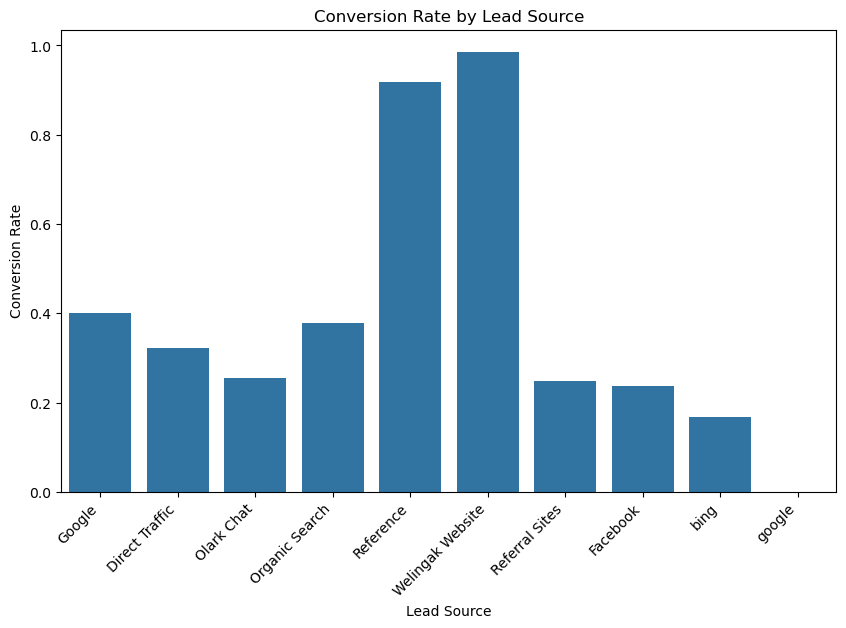

In [7]:
# Barplot for a key categorical variable vs target
plt.figure(figsize=(10, 6))
sns.barplot(x='Lead Source', y='Converted', data=leads_data, ci=None, order=leads_data['Lead Source'].value_counts().index[:10])
plt.xticks(rotation=45, ha='right')
plt.title("Conversion Rate by Lead Source")
plt.xlabel("Lead Source")
plt.ylabel("Conversion Rate")
plt.show()

In [8]:
# Step 1: Drop irrelevant or redundant columns
columns_to_drop = [
    'Prospect ID', 'Lead Number',  # Unique identifiers
    'Magazine', 'Receive More Updates About Our Courses',  # Constant value columns
    'Update me on Supply Chain Content', 'Get updates on DM Content',  # Constant values
    'I agree to pay the amount through cheque'  # Irrelevant for prediction
]

leads_data = leads_data.drop(columns=columns_to_drop, axis=1)

In [9]:
# Step 2: Handle missing values
# Replace 'Select' in categorical columns with NaN
leads_data.replace('Select', pd.NA, inplace=True)

# Impute missing categorical variables with mode
categorical_cols = leads_data.select_dtypes(include='object').columns
for col in categorical_cols:
    leads_data[col].fillna(leads_data[col].mode()[0], inplace=True)

# Impute missing numerical variables with median
numerical_cols = leads_data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    leads_data[col].fillna(leads_data[col].median(), inplace=True)

In [10]:
# Step 3: Address outliers by capping at 95th percentile
for col in ['TotalVisits', 'Page Views Per Visit']:
    leads_data[col] = leads_data[col].clip(upper=leads_data[col].quantile(0.95))

In [11]:
# Step 4: One-hot encode categorical variables
leads_data = pd.get_dummies(leads_data, drop_first=True)

In [12]:
# Step 5: Correlation analysis for feature selection
correlation_with_target = leads_data.corr()['Converted'].sort_values(ascending=False)

# Identify features with a correlation above a threshold (e.g., 0.05)
selected_features = correlation_with_target[abs(correlation_with_target) > 0.05].index.tolist()

# Exclude the target variable itself
selected_features = [feature for feature in selected_features if feature != 'Converted']

# Prepare the final dataset for modeling
X = leads_data[selected_features]
y = leads_data['Converted']

# Output the selected features and their correlation with the target variable
selected_features_summary = correlation_with_target[selected_features]
selected_features_summary

Total Time Spent on Website                             0.362483
Last Notable Activity_SMS Sent                          0.351845
Tags_Will revert after reading the email                0.339760
Last Activity_SMS Sent                                  0.325600
Lead Origin_Lead Add Form                               0.321702
What is your current occupation_Working Professional    0.313837
Lead Source_Reference                                   0.270830
Tags_Closed by Horizzon                                 0.251229
Lead Quality_Low in Relevance                           0.230770
Tags_Lost to EINS                                       0.168937
Asymmetrique Profile Score                              0.157824
Lead Source_Welingak Website                            0.154153
Asymmetrique Activity Score                             0.120331
Asymmetrique Activity Index_02.Medium                   0.118409
Specialization_Marketing Management                     0.065853
Lead Profile_Lateral Stud

In [13]:
# Prepare the final dataset with selected features
X = leads_data[selected_features]
y = leads_data['Converted']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [14]:
# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [15]:
# Predict on the test set
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1] #default -> 0.5

In [16]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

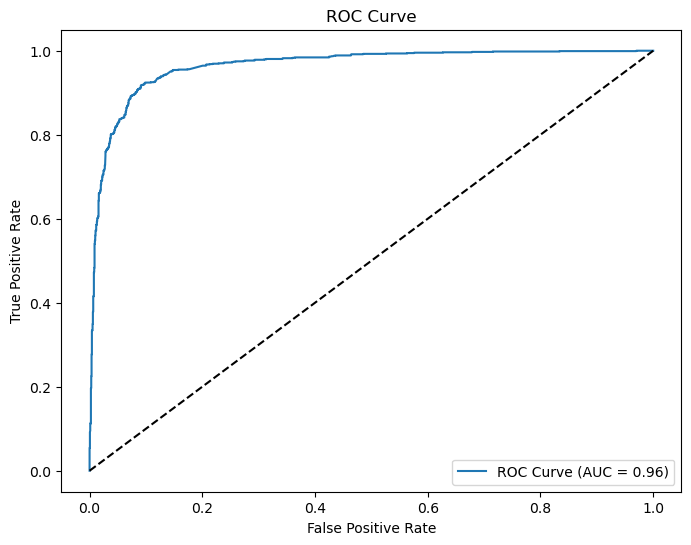

{'Accuracy': 0.9076479076479076,
 'Precision': 0.8911368015414258,
 'Recall': 0.8661048689138576,
 'F1 Score': 0.8784425451092117,
 'ROC AUC': 0.9641098384941358,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.92      0.93      0.93      1704\n           1       0.89      0.87      0.88      1068\n\n    accuracy                           0.91      2772\n   macro avg       0.90      0.90      0.90      2772\nweighted avg       0.91      0.91      0.91      2772\n'}

In [17]:
# Generate a classification report
classification_rep = classification_report(y_test, y_pred)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Display evaluation metrics and classification report
{
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Classification Report": classification_rep
}

In [18]:
# Step 1: Assign lead scores based on predicted probabilities
lead_scores = (y_pred_proba * 100).round(2)

# Add lead scores to the test dataset for reference
X_test_with_scores = X_test.copy()
X_test_with_scores['Lead Score'] = lead_scores
X_test_with_scores['Converted'] = y_test.values

In [19]:
# Step 2: Perform feature importance analysis
# Logistic regression coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Display the lead scores and feature importance

In [20]:
coefficients.head(10)

,Feature,Coefficient
9,Tags_Lost to EINS,6.205896
7,Tags_Closed by Horizzon,5.216502
2,Tags_Will revert after reading the email,2.510531
4,Lead Origin_Lead Add Form,1.980527
11,Lead Source_Welingak Website,1.714090
1,Last Notable Activity_SMS Sent,1.497249
16,Tags_Busy,1.045172
3,Last Activity_SMS Sent,0.928926
5,What is your current occupation_Working Profes...,0.910978
13,Asymmetrique Activity Index_02.Medium,0.629484


In [21]:
X_test_with_scores[["Lead Score", "Converted"]].head(10)

,Lead Score,Converted
8305,31.77,0
1591,77.10,1
8604,3.02,0
1333,6.91,0
4260,0.12,0
2357,98.15,1
1900,73.39,1
9077,1.27,0
6302,96.83,1
8158,89.48,1


# Assignment Questions

In [26]:
#Question 1

In [22]:
# Extract the top 3 features with the highest coefficients
top_features = coefficients.sort_values(by='Coefficient', ascending=False).head(3)

# Display the top 3 features
print("Top 3 Variables Contributing to Lead Conversion:")
print(top_features)

Top 3 Variables Contributing to Lead Conversion:
                                    Feature  Coefficient
9                         Tags_Lost to EINS     6.205896
7                   Tags_Closed by Horizzon     5.216502
2  Tags_Will revert after reading the email     2.510531


In [28]:
#Question 2

In [23]:
# Filter out the categorical/dummy variables based on the feature names
# Assuming categorical variables in this dataset are identified by having multiple levels in their names
categorical_features = coefficients[coefficients['Feature'].str.contains('_')]

# Extract the top 3 categorical/dummy variables with the highest positive coefficients
top_categorical_features = categorical_features.sort_values(by='Coefficient', ascending=False).head(3)

# Display the top 3 categorical/dummy variables
print("Top 3 Categorical/Dummy Variables to Focus On:")
print(top_categorical_features)


Top 3 Categorical/Dummy Variables to Focus On:
                                    Feature  Coefficient
9                         Tags_Lost to EINS     6.205896
7                   Tags_Closed by Horizzon     5.216502
2  Tags_Will revert after reading the email     2.510531


In [30]:
#Question3

In [31]:
#Question 4